In [1]:
import numpy as np
from math import sqrt

import datetime
import csv
import matplotlib.pyplot as plt

from pyspark.mllib.clustering import KMeans, KMeansModel

In [2]:
with open('data/detroit.csv') as f:
    csv_file = csv.reader(f)
    next(csv_file)
    crime_list = []
    for row in csv_file:
        crime_list.append(row)

In [3]:
data = []
for row in crime_list:
    crime_date = datetime.datetime.strptime(row[2], '%m/%d/%Y').date()
    crime_pos  = np.array([float(row[-2]), float(row[-1])])
    crime_type = row[3].split('-')[0].strip()
    crime_type = crime_type.split('(')[0].strip()
    crime_type = crime_type.split(',')[0].strip()
    data.append([crime_date, crime_pos, crime_type])

In [4]:
data_rdd = sc.parallelize(data)
histogram_year_rdd = data_rdd.map(lambda x: (x[0].month, 1)).reduceByKey(lambda x, y: x + y).sortByKey()
year_count = histogram_year_rdd.collect()
histogram_category_rdd = data_rdd.flatMap(lambda x: [(category, 1) for category in x[2]]).reduceByKey(lambda x, y: x + y).sortByKey()
category_count = histogram_category_rdd.collect()

In [5]:
def selection(item, choices):
    return choices is None or item in choices

In [6]:
def cluster(date_range, category_types, num_clusters):
    #Label data
    filtered_rdd = data_rdd.filter(lambda x: selection(x[0], date_range) and selection(x[2], category_types))
    pos_rdd = filtered_rdd.map(lambda x: x[1])
    clusters = KMeans.train(pos_rdd, num_clusters, maxIterations=100, initializationMode="random")
    label_rdd = pos_rdd.map(lambda x: [x, clusters.centers[clusters.predict(x)]])
    
    #Cluster and distribution
    return label_rdd, clusters

In [7]:
def sse(point, center):
    return sqrt(sum([i**2 for i in (point - center)]))

In [8]:
def error_plot(dates, categories, cluster_range):
    error = []
    for num_cluster in cluster_range:
        label_rdd, clusters = cluster(dates, categories, num_cluster)
        error.append(label_rdd.map(lambda x: sse(x[0], x[1])).reduce(lambda x, y: x + y))
    return error

In [14]:
errors = error_plot(None, None, range(1,21))

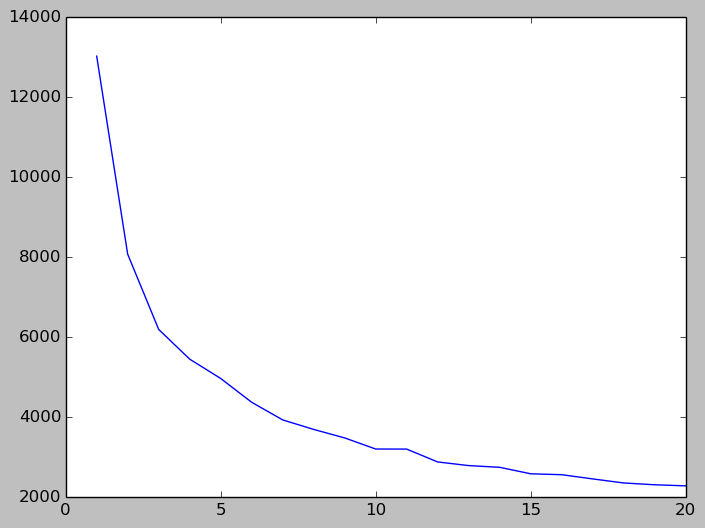

In [20]:
plt.plot(range(1, 21), errors)